# Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# for easily switching between classmates, we set up a computer_name variable and all used a uniform folder structure within
import os
computer_name = 'JoelAndersonDig'
os.chdir(f'C:\\Users\\{computer_name}')

# Installation Requirements and Environments
The following sets up environments and installs required packages.
## Requirements
To run YOLOv5, you need to have PyTorch installed, ideally with CUDA support for hardware acceleration via GPU. Next, you need to clone YOLOv5's git repository. Finally, you need to install the requirements.txt file from the YOLOv5 repo. That is a broad outline of what is needed to run YOLOv5.  
## Our Steps
The following shows the steps we took to run this locally. *Note that we started out with Google Colab for this project but we had a cumulative over 24 hours of GPU processing for this project so we had to move our project to our local computers for the processing.*  
The following commands may or may not work out of the box depending on the package managers you use for Python and the local environments you have set up.

In [3]:
# !conda create -n yolov5 python=3.9

In [4]:
!conda activate yolov5

In [5]:
# !pip install ipykernel

In [6]:
# !python -m ipykernel install --user --name yolov5 --display-name "yolov5"

In [7]:
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

In [8]:
# !git clone https://github.com/ultralytics/yolov5

In [9]:
# !pip install -qr yolov5/requirements.txt  # install requirements for yolov5

In [10]:
os.chdir('yolov5')

# Inspecting Images
Before we do much work on the images, let's explore what the raw images look like.

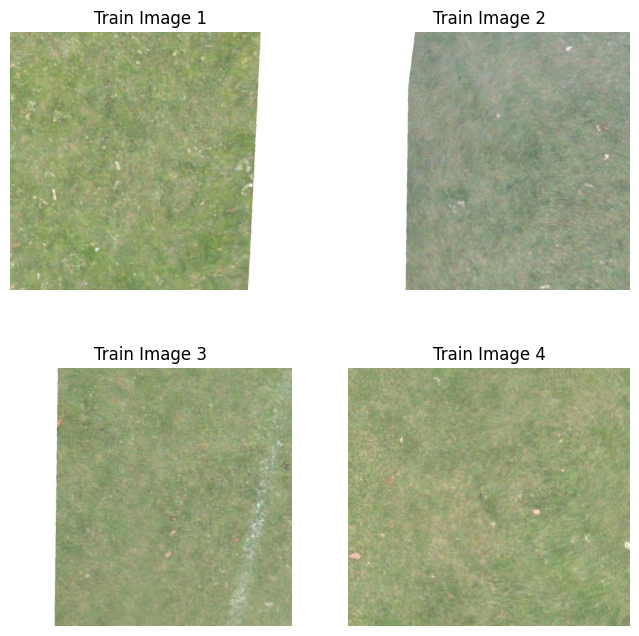

In [42]:
import glob
image_paths = glob.glob('data\\otherdata\\train\\images\\*.jpg')

import matplotlib.image as mpimg

plt.figure(figsize=(8, 8))
for ctr, file_path in enumerate(image_paths[:4]):
    plt.subplot(2, 2, ctr + 1)
    image = mpimg.imread(os.path.join(file_path))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Training Image {ctr+1}')

plt.show()

# Fine-tuning a YOLOv5 Model Using visDrone
As per YOLOv5's official documentation, we fine-tune visDrone using the maximum batch size our GPU supports using --batch -1.  
We use 300 epochs using YOLOv5's SGD optimizer and their default recemmended learning rate (0.01), decay (0.0005) and momentum (0.937) with 3 warmup epochs.

In [11]:
# fine-tune training YOLOv5 small
# !python train.py --img 640 --batch -1 --epochs 200 --data VisDrone.yaml --weights yolov5s.pt --name PTvisDroneSmall

In [12]:
# fine-tune training YOLOv5 large
# !python train.py --img 640 --batch -1 --epochs 200 --data VisDrone.yaml --weights yolov5l.pt --name PTvisDroneLarge

In [13]:
PTvisDroneLarge = pd.read_csv('runs\\train\\PTvisDroneLarge\\results.csv')
PTvisDroneSmall = pd.read_csv('runs\\train\\PTvisDroneSmall\\results.csv')

In [14]:
# standardize number of epochs run
PTvisDroneLarge = PTvisDroneLarge.iloc[:200,:]
PTvisDroneSmall = PTvisDroneSmall.iloc[:200,:]

In [15]:
PTvisDroneLarge.head(2)

,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95,val/box_loss,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
0,0,0.12122,0.14505,0.046654,0.30484,0.20391,0.11745,0.051260,0.103230,0.23238,0.039485,0.070056,0.003327,0.003327
1,1,0.10588,0.16824,0.035154,0.48614,0.21215,0.16830,0.076478,0.099815,0.22835,0.035558,0.040034,0.006639,0.006639


In [16]:
# create function to calculate f1 score
def f1_scores(precision_vector, recall_vector):
    fs=[]
    for i in range(len(precision_vector)):
        fs.append(2* (precision_vector[i] * recall_vector[i])/(precision_vector[i] + recall_vector[i]))
    return fs

In [17]:
PTvisDroneSmall['f1_score'] = f1_scores(PTvisDroneSmall.iloc[:,4], PTvisDroneSmall.iloc[:,5])
PTvisDroneLarge['f1_score'] = f1_scores(PTvisDroneLarge.iloc[:,4], PTvisDroneLarge.iloc[:,5])

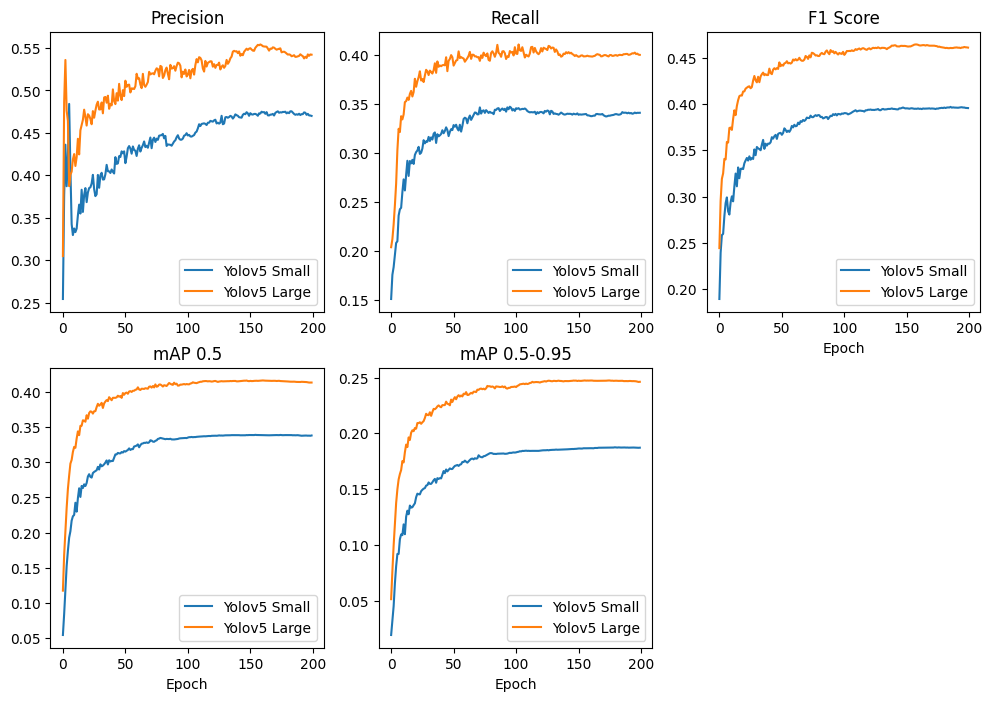

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(PTvisDroneSmall.iloc[:,4], label='Yolov5 Small')
plt.plot(PTvisDroneLarge.iloc[:,4], label='Yolov5 Large')
plt.legend(loc='lower right')
plt.title('Precision')


plt.subplot(2,3,2)
plt.plot(PTvisDroneSmall.iloc[:,5], label='Yolov5 Small')
plt.plot(PTvisDroneLarge.iloc[:,5], label='Yolov5 Large')
plt.legend(loc='lower right')
plt.title('Recall')

plt.subplot(2,3,3)
plt.plot(PTvisDroneSmall.iloc[:,14], label='Yolov5 Small')
plt.plot(PTvisDroneLarge.iloc[:,14], label='Yolov5 Large')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('F1 Score')

plt.subplot(2,3,4)
plt.plot(PTvisDroneSmall.iloc[:,6], label='Yolov5 Small')
plt.plot(PTvisDroneLarge.iloc[:,6], label='Yolov5 Large')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5')

plt.subplot(2,3,5)
plt.plot(PTvisDroneSmall.iloc[:,7], label='Yolov5 Small')
plt.plot(PTvisDroneLarge.iloc[:,7], label='Yolov5 Large')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5-0.95')

plt.show()

# Fine-tuning a YOLOv5 Model using the Binghamton Landmine Dataset

In [20]:
# fine-tune training YOLOv5 small using visDrone pre-trained weights
# python train.py --img 640 --batch 4 --epochs 150 --data Binghamton.yaml --weights runs/train/PTvisDroneSmall/weights/best.pt --name visDroneSmall

In [21]:
# fine-tune training YOLOv5 large using visDrone pre-trained weights
# !python train.py --img 640 --batch 4 --epochs 150 --data Binghamton.yaml --weights runs/train/PTvisDroneLarge/weights/best.pt --name visDroneLarge

In [22]:
# fine-tune training YOLOv5 small using COCO pre-trained weights
# !python train.py --img 640 --batch 4 --epochs 150 --data Binghamton.yaml --weights yolov5s.pt --name COCOSmall

In [23]:
# fine-tune training YOLOv5 large using COCO pre-trained weights
# !python train.py --img 640 --batch 4 --epochs 150 --data Binghamton.yaml --weights yolov5l.pt --name COCOLarge

In [24]:
visDroneSmall = pd.read_csv('runs\\train\\visDroneSmall\\results.csv')
visDroneLarge = pd.read_csv('runs\\train\\visDroneLarge\\results.csv')
COCOSmall = pd.read_csv('runs\\train\\COCOSmall\\results.csv')
COCOLarge = pd.read_csv('runs\\train\\COCOLarge\\results.csv')

In [25]:
visDroneSmall['f1_score'] = f1_scores(visDroneSmall.iloc[:,4], visDroneSmall.iloc[:,5])
visDroneLarge['f1_score'] = f1_scores(visDroneLarge.iloc[:,4], visDroneLarge.iloc[:,5])
COCOSmall['f1_score'] = f1_scores(COCOSmall.iloc[:,4], COCOSmall.iloc[:,5])
COCOLarge['f1_score'] = f1_scores(COCOLarge.iloc[:,4], COCOLarge.iloc[:,5])

## COCO Small vs. Large

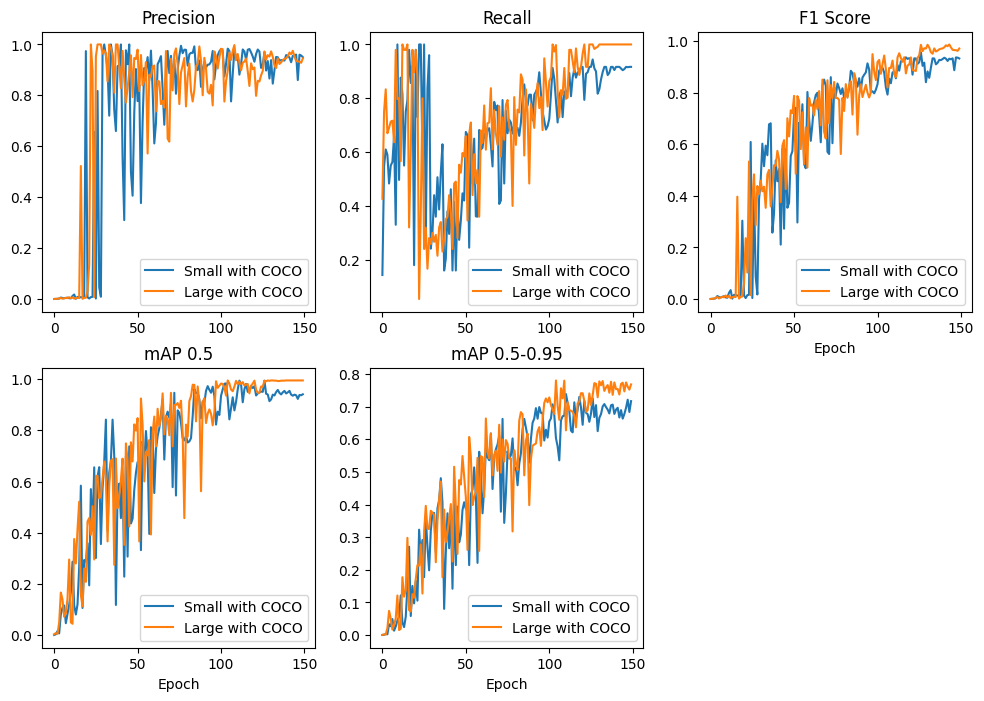

In [27]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(COCOSmall.iloc[:,4], label='Small with COCO')
plt.plot(COCOLarge.iloc[:,4], label='Large with COCO')
plt.legend(loc='lower right')
plt.title('Precision')

plt.subplot(2,3,2)
plt.plot(COCOSmall.iloc[:,5], label='Small with COCO')
plt.plot(COCOLarge.iloc[:,5], label='Large with COCO')
plt.legend(loc='lower right')
plt.title('Recall')

plt.subplot(2,3,3)
plt.plot(COCOSmall.iloc[:,14], label='Small with COCO')
plt.plot(COCOLarge.iloc[:,14], label='Large with COCO')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('F1 Score')

plt.subplot(2,3,4)
plt.plot(COCOSmall.iloc[:,6], label='Small with COCO')
plt.plot(COCOLarge.iloc[:,6], label='Large with COCO')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5')

plt.subplot(2,3,5)
plt.plot(COCOSmall.iloc[:,7], label='Small with COCO')
plt.plot(COCOLarge.iloc[:,7], label='Large with COCO')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5-0.95')

plt.show()

## VisDrone Small vs. Large

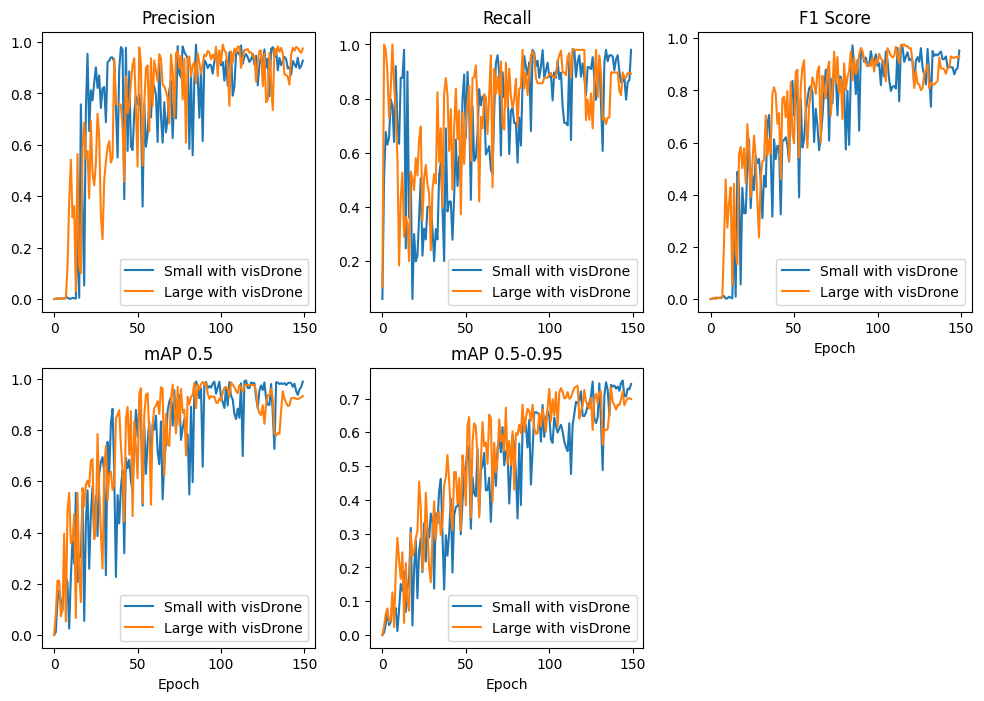

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(visDroneSmall.iloc[:,4], label='Small with visDrone')
plt.plot(visDroneLarge.iloc[:,4], label='Large with visDrone')
plt.legend(loc='lower right')
plt.title('Precision')

plt.subplot(2,3,2)
plt.plot(visDroneSmall.iloc[:,5], label='Small with visDrone')
plt.plot(visDroneLarge.iloc[:,5], label='Large with visDrone')
plt.legend(loc='lower right')
plt.title('Recall')

plt.subplot(2,3,3)
plt.plot(visDroneSmall.iloc[:,14], label='Small with visDrone')
plt.plot(visDroneLarge.iloc[:,14], label='Large with visDrone')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('F1 Score')

plt.subplot(2,3,4)
plt.plot(visDroneSmall.iloc[:,6], label='Small with visDrone')
plt.plot(visDroneLarge.iloc[:,6], label='Large with visDrone')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5')

plt.subplot(2,3,5)
plt.plot(visDroneSmall.iloc[:,7], label='Small with visDrone')
plt.plot(visDroneLarge.iloc[:,7], label='Large with visDrone')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5-0.95')

plt.show()

## Moving Average with the Above Combined
With fewer training images, we have jagged plots, so we use a moving average to smooth out the plots to make them more interpretable.  
This may not help much so we didn't include it in our final report.  

In [29]:
# define moving average function with a default of 5 steps
def moving_average(x, w=5):
    return np.convolve(x, np.ones(w), 'valid') / w

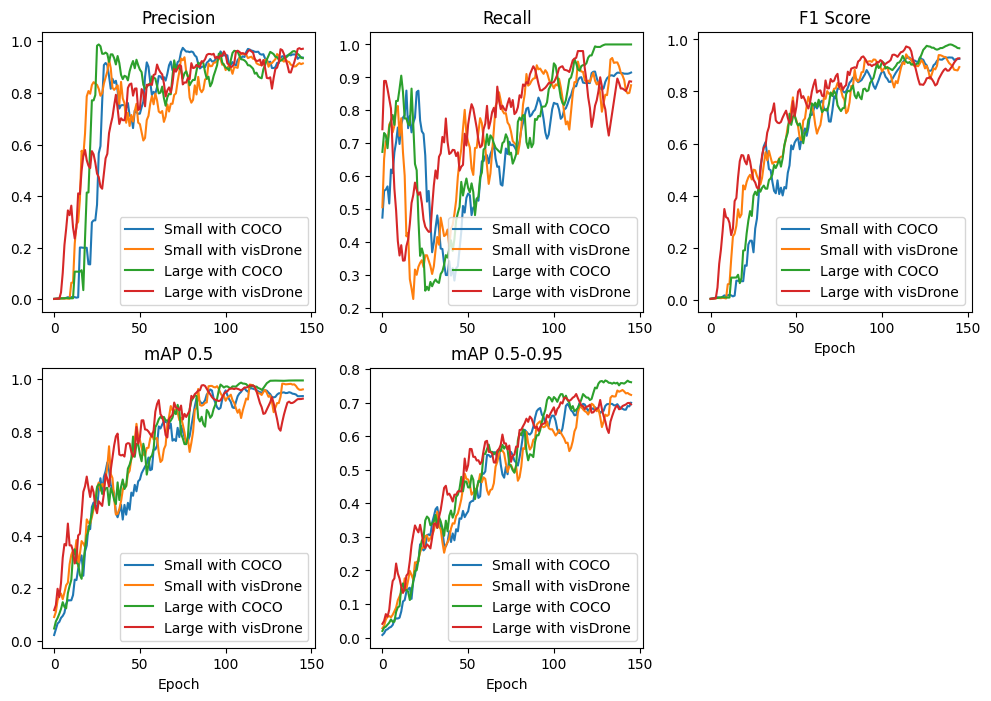

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(moving_average(COCOSmall.iloc[:,4]), label='Small with COCO')
plt.plot(moving_average(visDroneSmall.iloc[:,4]), label='Small with visDrone')
plt.plot(moving_average(COCOLarge.iloc[:,4]), label='Large with COCO')
plt.plot(moving_average(visDroneLarge.iloc[:,4]), label='Large with visDrone')
plt.legend(loc='lower right')
plt.title('Precision')

plt.subplot(2,3,2)
plt.plot(moving_average(COCOSmall.iloc[:,5]), label='Small with COCO')
plt.plot(moving_average(visDroneSmall.iloc[:,5]), label='Small with visDrone')
plt.plot(moving_average(COCOLarge.iloc[:,5]), label='Large with COCO')
plt.plot(moving_average(visDroneLarge.iloc[:,5]), label='Large with visDrone')
plt.legend(loc='lower right')
plt.title('Recall')

plt.subplot(2,3,3)
plt.plot(moving_average(COCOSmall.iloc[:,14]), label='Small with COCO')
plt.plot(moving_average(visDroneSmall.iloc[:,14]), label='Small with visDrone')
plt.plot(moving_average(COCOLarge.iloc[:,14]), label='Large with COCO')
plt.plot(moving_average(visDroneLarge.iloc[:,14]), label='Large with visDrone')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('F1 Score')

plt.subplot(2,3,4)
plt.plot(moving_average(COCOSmall.iloc[:,6]), label='Small with COCO')
plt.plot(moving_average(visDroneSmall.iloc[:,6]), label='Small with visDrone')
plt.plot(moving_average(COCOLarge.iloc[:,6]), label='Large with COCO')
plt.plot(moving_average(visDroneLarge.iloc[:,6]), label='Large with visDrone')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5')

plt.subplot(2,3,5)
plt.plot(moving_average(COCOSmall.iloc[:,7]), label='Small with COCO')
plt.plot(moving_average(visDroneSmall.iloc[:,7]), label='Small with visDrone')
plt.plot(moving_average(COCOLarge.iloc[:,7]), label='Large with COCO')
plt.plot(moving_average(visDroneLarge.iloc[:,7]), label='Large with visDrone')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('mAP 0.5-0.95')

plt.show()

# Comparing Results
The output below shows results for ksf-casing and pfm-1 classes. These refer to cassetes (large objects that distribute landmines while flying through the air) and pfm-1 (the landmines we are specifically trying to predict). We analyze the results for pfm-1s.

In [46]:
!python val.py --img 640 --data Binghamton.yaml --weights runs/train/visDroneSmall/weights/best.pt --name visDroneSmall --save-txt --task test

val: data=C:\Users\JoelAndersonDig\yolov5\data\Binghamton.yaml, weights=['runs/train/visDroneSmall/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=visDroneSmall, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]
test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]

                 Class     Images  Instances          P        

In [37]:
!python val.py --img 640 --data Binghamton.yaml --weights runs/train/visDroneLarge/weights/best.pt --name visDroneLarge --save-txt --task test

val: data=C:\Users\JoelAndersonDig\yolov5\data\Binghamton.yaml, weights=['runs/train/visDroneLarge/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=visDroneLarge, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients

test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]
test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP

In [38]:
!python val.py --img 640 --data Binghamton.yaml --weights runs/train/COCOSmall/weights/best.pt --name COCOSmall --save-txt --task test

val: data=C:\Users\JoelAndersonDig\yolov5\data\Binghamton.yaml, weights=['runs/train/COCOSmall/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=COCOSmall, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients

test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]
test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP5

In [39]:
!python val.py --img 640 --data Binghamton.yaml --weights runs/train/COCOLarge/weights/best.pt --name COCOLarge --save-conf --task test

val: data=C:\Users\JoelAndersonDig\yolov5\data\Binghamton.yaml, weights=['runs/train/COCOLarge/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=runs\val, name=COCOLarge, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients

test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]
test: Scanning C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\labels.cache... 191 images, 160 backgrounds, 0 corrupt: 100%|##########| 191/191 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP

In [31]:
# pulling results from 'test' images from above output for pfm-1
final_results = pd.DataFrame({
    'Weights': ['Small COCO', 'Small visDrone', 'Large COCO', 'Large visDrone'], 
    'Precision': [0.423, 0.951, 0.498, 0.822], 
    'Recall': [0.704, 0.722, 0.815, 0.683], 
    'F1 Score': [0.528, 0.821, 0.618, 0.746], 
    'mAP50': [0.578, 0.841, 0.792, 0.791],
    'mAP50:95': [0.351, 0.544, 0.493, 0.547]
})

In [32]:
plot_df = final_results.T

# Set the "Weights" column as the new column names
plot_df.columns = plot_df.iloc[0]

# Drop the first row, which is now the duplicate of the new column names
plot_df = plot_df.drop(plot_df.index[0])

plot_df

Weights,Small COCO,Small visDrone,Large COCO,Large visDrone
Precision,0.423,0.951,0.498,0.822
Recall,0.704,0.722,0.815,0.683
F1 Score,0.528,0.821,0.618,0.746
mAP50,0.578,0.841,0.792,0.791
mAP50:95,0.351,0.544,0.493,0.547


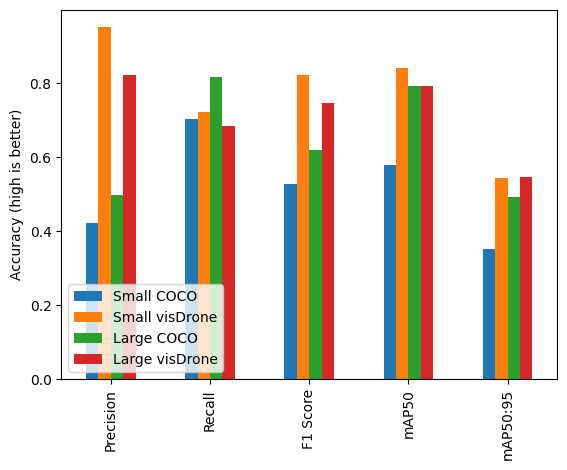

In [33]:
plot_df.plot.bar()
plt.ylabel('Accuracy (high is better)')
plt.legend(loc='lower left')
plt.show()

# Inference
Now we will run some detection on images from our test set to see how well the final model performs.

In [57]:
# run detection for visDroneSmall
!python detect.py --img 640 --source data/otherdata/test/images --weights runs/train/visDroneSmall/weights/best.pt --name visDroneSmall

detect: weights=['runs/train/visDroneSmall/weights/best.pt'], source=data/otherdata/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=visDroneSmall, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.03061062f4c6d97446bca5c489cbbb3a.jpg: 640x640 1 ksf-casing, 1 pfm-1, 12.0ms
image 2/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.04048f629031468780a3d1c316666430

In [63]:
# run detection for COCOSmall
!python detect.py --img 640 --source data/otherdata/test/images --weights runs/train/COCOSmall/weights/best.pt --name COCOSmall

detect: weights=['runs/train/COCOSmall/weights/best.pt'], source=data/otherdata/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=COCOSmall, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.03061062f4c6d97446bca5c489cbbb3a.jpg: 640x640 1 pfm-1, 7.0ms
image 2/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.04048f629031468780a3d1c316666430.jpg: 640x640 1 pfm-1, 

## visDroneSmall vs. COCOSmall
Below we will see a comparison of the images for visDroneSmall vs. COCOSmall. Note that the visDroneSmall model correct detects the pfm-1 with 100% confidence whereas the COCOSmall does not meet the confidence threshold (0.25) to identify the same pfm-1. This shows the power of fine-tuning with the visDrone dataset compared to fine-tuning with COCO alone.

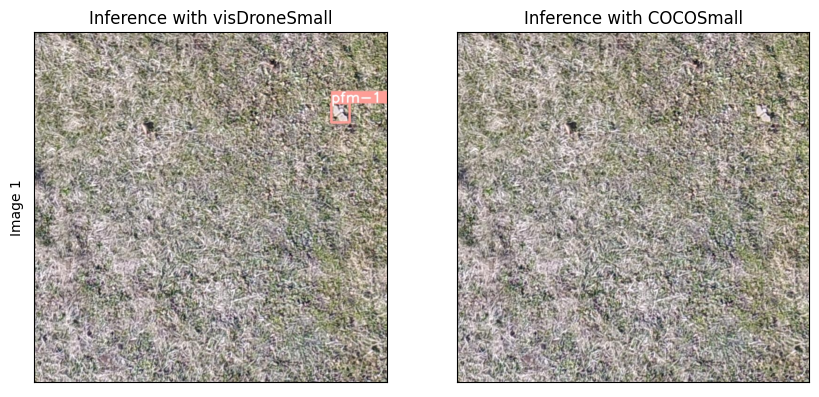

In [75]:
# load images
image_visDroneSmall = plt.imread('runs\\detect\\visDroneSmall\\Phan4_200316_F02_RGB_jpg.rf.0a8faf0afbea50a28e32a08b1b7dd6f7.jpg')
image_COCOSmall = plt.imread('runs\\detect\\COCOSmall\\Phan4_200316_F02_RGB_jpg.rf.0a8faf0afbea50a28e32a08b1b7dd6f7.jpg')

# display images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image_visDroneSmall)
plt.title('Inference with visDroneSmall')
plt.ylabel('Image 1')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(image_COCOSmall)
plt.title('Inference with COCOSmall')
plt.xticks([])
plt.yticks([])

plt.show()

## visDroneLarge vs. COCOLarge
Now we repeat the object detection with the large models and a more obscured object. Both of these models identify the landmine correctly, but the COCOLarge model only does so correctly with a low threshol of 0.25. 

In [66]:
# run detection for visDroneLarge
!python detect.py --img 640 --source data/otherdata/test/images --weights runs/train/visDroneLarge/weights/best.pt --name visDroneLarge

detect: weights=['runs/train/visDroneLarge/weights/best.pt'], source=data/otherdata/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=visDroneLarge, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.03061062f4c6d97446bca5c489cbbb3a.jpg: 640x640 1 ksf-casing, 1 pfm-1, 25.7ms
image 2/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.04048f629031468780a3d1c3166664

In [67]:
# run detection for COCOLarge
!python detect.py --img 640 --source data/otherdata/test/images --weights runs/train/COCOLarge/weights/best.pt --name COCOLarge

detect: weights=['runs/train/COCOLarge/weights/best.pt'], source=data/otherdata/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=COCOLarge, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-24-gf8539a6 Python-3.9.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.03061062f4c6d97446bca5c489cbbb3a.jpg: 640x640 1 ksf-casing, 1 pfm-1, 21.9ms
image 2/191 C:\Users\JoelAndersonDig\yolov5\data\otherdata\test\images\Phan4_200316_F02_RGB_jpg.rf.04048f629031468780a3d1c316666430.jpg: 

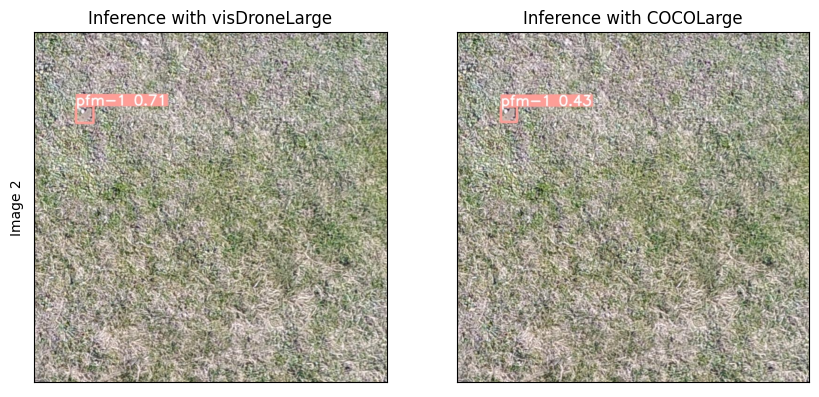

In [76]:
# load images
image_visDroneLarge = plt.imread('runs\\detect\\visDroneLarge\\Phan4_200316_F02_RGB_jpg.rf.1b3a5d84e8ac1b6c44f19fc589c693e9.jpg')
image_COCOLarge = plt.imread('runs\\detect\\COCOLarge\\Phan4_200316_F02_RGB_jpg.rf.1b3a5d84e8ac1b6c44f19fc589c693e9.jpg')

# display images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image_visDroneLarge)
plt.title('Inference with visDroneLarge')
plt.ylabel('Image 2')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(image_COCOLarge)
plt.title('Inference with COCOLarge')
plt.xticks([])
plt.yticks([])

plt.show()

In [11]:
!conda activate yolov5

In [1]:
!jupyter nbconvert --to PDF "Comparing YOLOv5 Models.ipynb" --allow-chromium-download

[NbConvertApp] Converting notebook Comparing YOLOv5 Models.ipynb to PDF
[NbConvertApp] ERROR | Error while converting 'Comparing YOLOv5 Models.ipynb'
Traceback (most recent call last):
  File "C:\Users\JoelAndersonDig\.conda\envs\tf_gpu_pip\lib\site-packages\nbconvert\nbconvertapp.py", line 435, in export_single_notebook
    output, resources = self.exporter.from_filename(notebook_filename, resources=resources)
  File "C:\Users\JoelAndersonDig\.conda\envs\tf_gpu_pip\lib\site-packages\nbconvert\exporters\exporter.py", line 190, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "C:\Users\JoelAndersonDig\.conda\envs\tf_gpu_pip\lib\site-packages\nbconvert\exporters\exporter.py", line 208, in from_file
    return self.from_notebook_node(nbformat.read(file_stream, as_version=4), resources=resources, **kw)
  File "C:\Users\JoelAndersonDig\.conda\envs\tf_gpu_pip\lib\site-packages\nbconvert\exporters\pdf.py", line 168, in from_notebook_node
    latex, resources = s

In [4]:
!pip install texlive texlive-xetex texlive-latex-extra pandoc

ERROR: Could not find a version that satisfies the requirement texlive (from versions: none)
ERROR: No matching distribution found for texlive

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!winget install pandoc